## BMI-206 Course Project
### Group 3 
#### Members:
- Xintong (Zoe) Chen
- Isobel Beasley
- Abolfazl (Abe) Arab

In [28]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from glob import glob

In [29]:
def read_multiple_files(files):
    
    dfs = {}

    for name, file in files:
        df = pd.read_csv(file, sep='\t', header=0).dropna(axis=1, how='all')
        print(name, df.shape)
        df.insert(df.shape[-1], column='source', value=name)
        dfs[name] = df

    return dfs

___

### GWAS data and analysis
[issue link](https://github.com/abearab/BMI-206-Class-Project/issues/2)

___
First, running @IJbeasley codes to gather fine-mapping data from the GWAS catalog.

In [30]:
# !bash code/finemap/download_finemap.sh 

In [31]:
fine_map_df = pd.read_csv(
    "output/fine_map/all_finngen_trait_cs_filtered.tsv.gz",
    sep='\t'
)

___

#### Fig 4. a-c
(GWAS Manhattan plot by @IJbeasley)

In [32]:
##################### Figure 4a. ################# 

# 6q15
# 93100001-99500000 hg19 ucsc browser
# 92390283-99052124 liftover from hg19 to hg38
# in hg38 88000001-93100000 ucsc browser


######################## Figure 4 b. ####################### 
# 4p15.2

# 21300001-27700000 hg19
# 21298378-27698378 hg38


##################### Figure 4c ######################### 
# 11p14.1
# hg38 liftover 27178454-30978453
# hg19 27200001-31000000

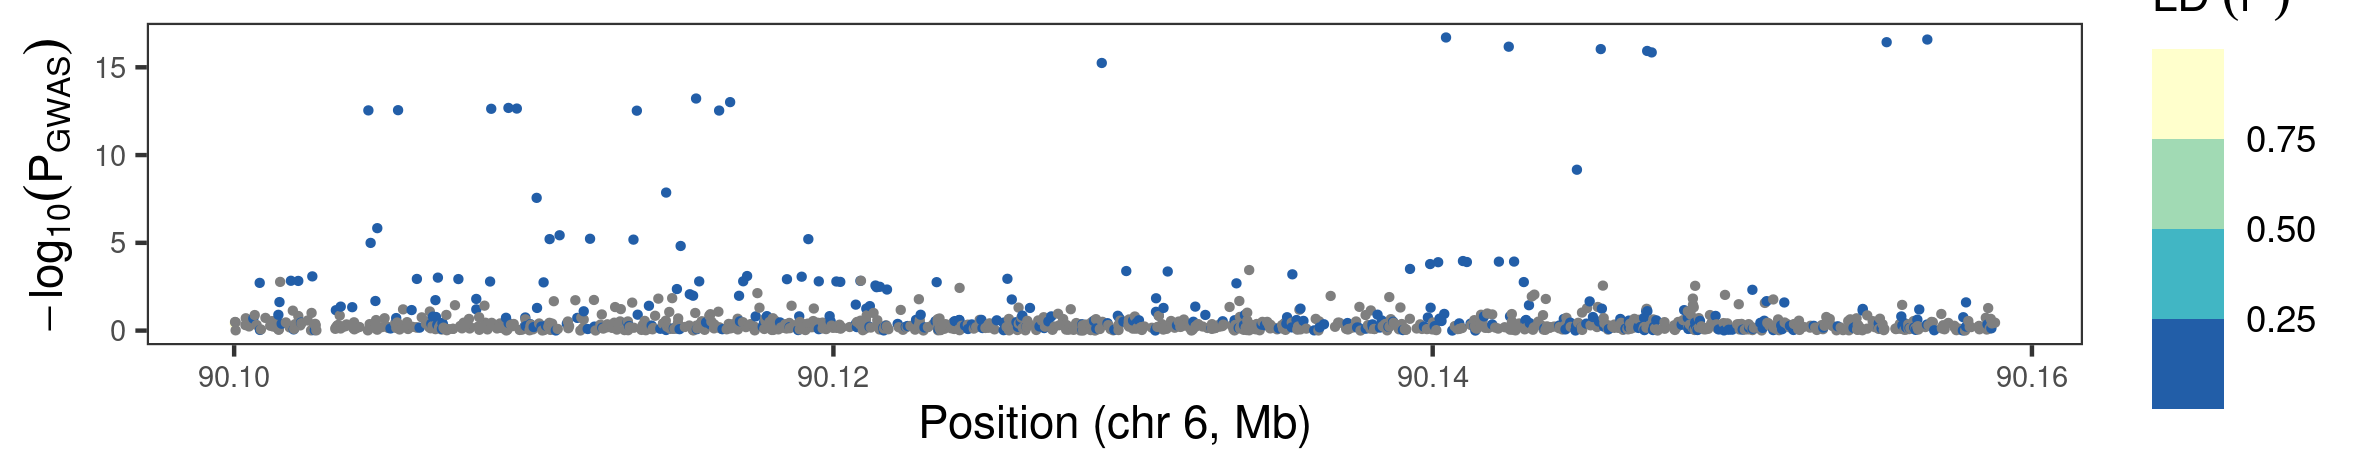

In [33]:
%matplotlib inline
from IPython.display import Image

# show a png file
Image(filename='figures/t1d_uk_bb.h.filt.fig4a.png')

### Single-cell data and analysis
[issue link](https://github.com/abearab/BMI-206-Class-Project/issues/3)

data: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE243917

___
R Scripts

In [34]:
# suppressMessages(suppressWarnings(library('SCENT')))
# suppressMessages(suppressWarnings(library('Seurat')))
# suppressMessages(suppressWarnings(library('SingleCellExperiment')))
# suppressMessages(suppressWarnings(library('tidyverse')))
# suppressMessages(suppressWarnings(library('anndata')))

In [35]:
# library('Matrix')

In [36]:
# # Create SingleCellExperiment objects that points to on-disk H5AD file
# rna_h5ad_file = 'data/GSE243917_genesXcells_ALL_raw.h5ad'
# atac_h5ad_file = 'data/GSE243917_peaksXcells_ALL_raw.h5ad'

# rna <- anndata::read_h5ad(rna_h5ad_file)
# atac <- anndata::read_h5ad(atac_h5ad_file)

# # Convert to dgCMatrix using Matrix package
# rna$X <- Matrix(rna$X, "dgCMatrix")
# atac$X <- Matrix(atac$X, "dgCMatrix")

In [37]:
# SCENT_obj <- SCENT::CreateSCENTObj(
#     rna = rna$X,
#     atac = atac$X,
#     meta.data = rna$obs,
#     peak.info = atac$obs,
#     covariates = c("log(nUMI)","percent.mito","sample", "batch"), 
#     celltypes = "ct" # cell type column
# )

___

| Column | Descriptions | 
| ------ | ------------ |
| gene | The gene(-peak) pair in each test statistics
| peak | The (gene-)peak pair in each test statistics
| beta | The regression coefficient from primary Poisson regression
| se | The standard error from primary Poisson regression
| z | The Z score from primary Poisson regression
| p | The raw p value from primary Poisson regression
| boot_basic_p | The bootstrap p value calculated from bootstrapping analyses

In [38]:
res_1 = pd.read_csv('data/zoe-scent-results/500kb_Tcell_allcvar.txt.gz', sep=' ')
res_1['-log10(p)'] = -np.log10(res_1['p'])
res_1['-log10(boot_basic_p)'] = -np.log10(res_1['boot_basic_p'])

/pollard/home/aabe/miniconda3/envs/SCENT/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [44]:
# set(fine_map_df['region']) & set(res_1['peak'].to_list())

In [50]:
# bed file
# columns: chr, start, end, p
res_1_bed = pd.concat(
    {
        'chr':res_1['peak'].str.split(':').str[0],
        'start':res_1['peak'].str.split(':').str[1].str.split('-').str[0].astype(int),
        'end':res_1['peak'].str.split(':').str[1].str.split('-').str[1].astype(int),
        # 'name':res_1['gene']+'::'+res_1['peak'],
        'score':res_1['beta'],
        # 'strand':pd.Series('.',index=res_1.index),
    },axis=1
)

In [51]:
res_1_bed.to_csv('data/zoe-scent-results/500kb_Tcell_allcvar.bed', sep='\t', index=False, header=False)

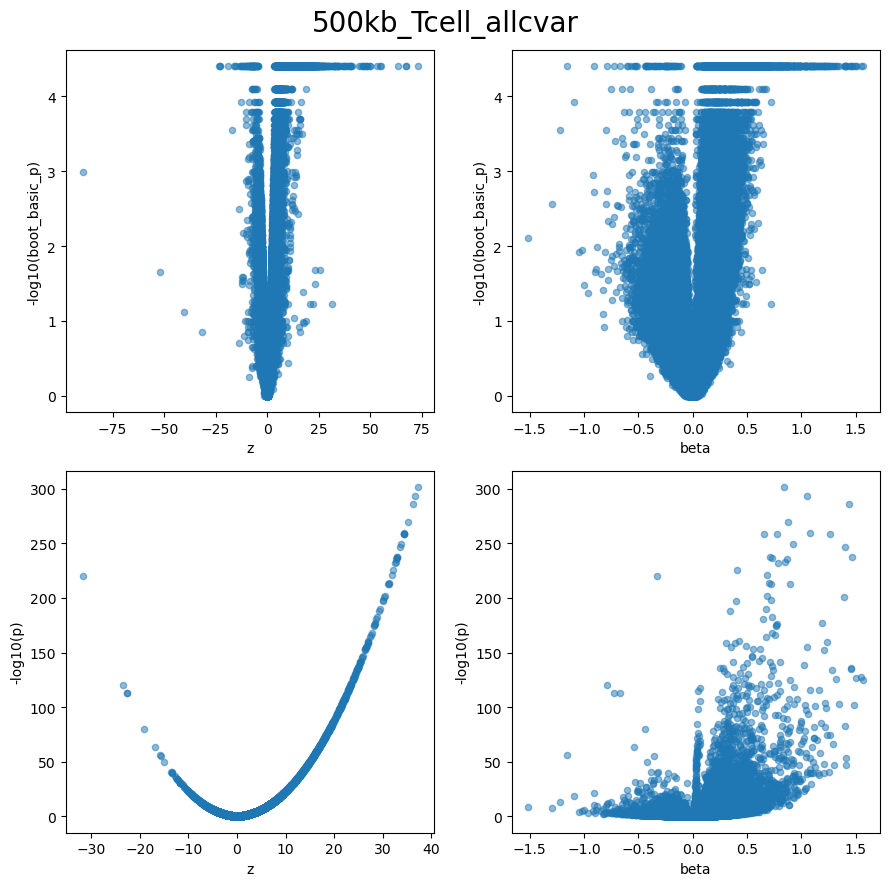

In [52]:
# draw volcano plot of z vs -log10(p) and color by source

fig, axes = plt.subplots(2,2, figsize=(9,9))

res_1.plot.scatter(x='z', y='-log10(boot_basic_p)', alpha=0.5, ax=axes[0,0])
res_1.plot.scatter(x='beta', y='-log10(boot_basic_p)', alpha=0.5, ax=axes[0,1])
res_1.plot.scatter(x='z', y='-log10(p)', alpha=0.5, ax=axes[1,0])
res_1.plot.scatter(x='beta', y='-log10(p)', alpha=0.5, ax=axes[1,1])

plt.suptitle('500kb_Tcell_allcvar', fontsize=20)
plt.tight_layout()
plt.show()

___
preprocessed files from the SCENT paper:

In [53]:
files = [
    (os.path.basename(file).replace('_allqced_bootpkg_nopc_allCT.FDR0.10.txt.gz',''), file)
    for file in glob('data/enhancer-gene-links-from-the-paper/*.txt.gz')
]

In [54]:
dfs = read_multiple_files(gwas_files)

df = pd.concat(dfs.values())
df['-log10(p)'] = -np.log10(df['p'])
df['-log10(boot_p)'] = -np.log10(df['boot_p'])

menorrhagia_uk_bb (56368, 22)
finngen_atopic_derm (2944738, 19)
endo_uk_bb (56368, 22)
t1d_uk_bb (10502449, 18)
ra_uk_bb (56369, 22)
age_meno_uk_bb (33106, 17)
hypo_uk_bb (56126, 22)
ovary_cys_uk_bb (56369, 22)


KeyError: 'p'

In [ ]:
df.head()

,gene,peak,beta,se,z,p,boot_p,fdr,celltype,source,-log10(p),-log10(boot_p)
0,ABCB1,chr7-87628077-87628577,0.500706,0.053585,9.344141,9.263862e-21,0.00004,0.004394,CD4T,NEAT,20.033208,4.397940
1,ABCB1,chr7-87933922-87934422,0.365729,0.061718,5.925819,3.107441e-09,0.00024,0.020356,CD4T,NEAT,8.507597,3.619789
2,ABCC4,chr13-95185812-95186312,0.725145,0.127990,5.665620,1.464936e-08,0.00004,0.004394,CD4T,NEAT,7.834181,4.397940
3,ABCG1,chr21-42228010-42228510,0.258218,0.061930,4.169491,3.052810e-05,0.00064,0.044259,CD4T,NEAT,4.515300,3.193820
4,ACBD3,chr1-225924103-225924603,0.228162,0.064049,3.562334,3.675717e-04,0.00120,0.070984,CD4T,NEAT,3.434658,2.920819


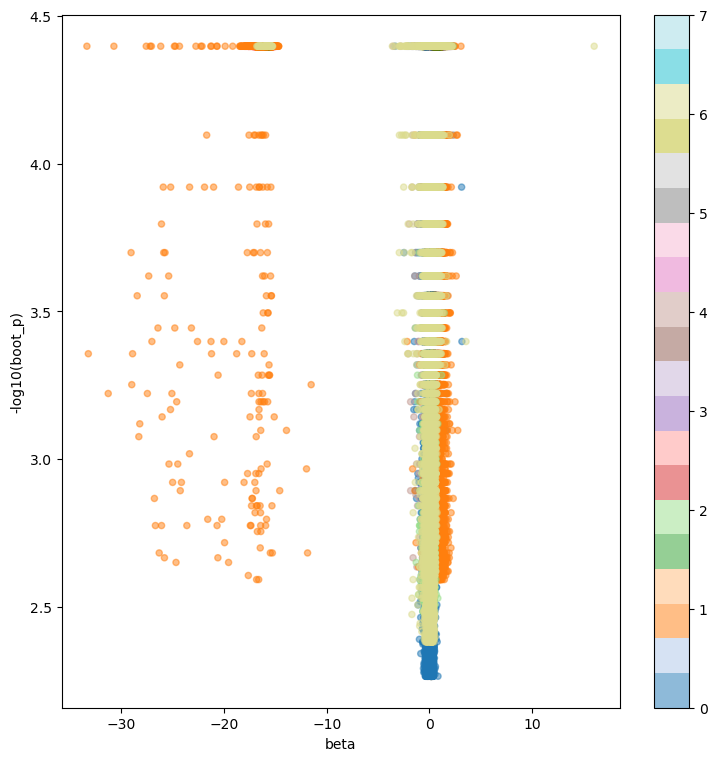

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))

df.plot.scatter(
    x='beta', y='-log10(boot_p)', 
    alpha=0.5, 
    c=df['source'].astype('category').cat.codes, 
    cmap='tab20', 
    ax=ax
)

plt.show()

### Enrichment analysis
[issue link](https://github.com/abearab/BMI-206-Class-Project/issues/5)

**Aim:** Causal variant enrichment analysis

**Tasks:**
- [ ] Reimplement enrichment analysis similar to the SCENT paper
- [ ] 

___
From our proposal:
> To replicate and expand upon the paper’s disease enrichment analysis of the causal variants identified with SCENT, we will create a set of disease causal variants by filtering the FinnGen fine-mapping results for the most reliable identified fine-mapped traits (e.g., number of case > 1,000) and variants (high purity of casual sets). 

> To evaluate the SCENT’s outcome, Sakaue et al. defined and evaluated causal enrichment for GWAS, eQTLs, caQTL or other ground truth resources such as bulk or single-cell-based enhancer–gene maps (Fig 3, S6-S8). We found this as a useful part of the paper to focus on for more in-depth statistical analysis. We will implement a “causal variant enrichment analysis” formula through custom codes in R or python. As we move forward, we will decide what exact analysis we can perform. We have lots of examples from the sub-figures but we can also go beyond that, for instance we can evaluate what are the effects of changing covariates in the SCENT pipeline.


In [ ]:
gwas_dfs['hypo_uk_bb']

In [55]:
from genomicranges import GenomicRanges

In [83]:
hypo_uk_bb_df = gwas_dfs['hypo_uk_bb'][['hm_chrom','hm_pos']].astype(int)
hypo_uk_bb_df.columns = ['seqnames','starts']
hypo_uk_bb_df['seqnames'] = 'chr' + hypo_uk_bb_df['seqnames'].astype(str)
hypo_uk_bb_df['ends'] = hypo_uk_bb_df['starts'] + 1

___

In [93]:
hypo_uk_bb_gr = GenomicRanges.from_pandas(hypo_uk_bb_df)

In [101]:
print(hypo_uk_bb_gr)

GenomicRanges with 56126 ranges and 0 metadata columns
      seqnames                ranges          strand
         <str>             <IRanges> <ndarray[int8]>
    0     chr4         85792 - 85793               *
    1     chr4         85991 - 85992               *
    2     chr4         86033 - 86034               *
           ...                   ...             ...
56123    chr11 134374716 - 134374717               *
56124    chr11 134382005 - 134382006               *
56125    chr11 134383981 - 134383982               *
------
seqinfo(3 sequences): chr11 chr4 chr6


related links:
- https://biocpy.github.io/GenomicRanges/tutorial.html#overlap-based-methodsm

###

In [ ]:
%reload_ext watermark
%watermark
%watermark --iversions

Last updated: 2024-11-19T11:31:04.324646-08:00

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.29.0

Compiler    : GCC 13.3.0
OS          : Linux
Release     : 4.18.0-477.27.1.el8_8.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

pandas: 2.2.3

